In [1]:
from collections import OrderedDict
from contextlib import contextmanager
from functools import partial
import random

# TODO(eric.cousineau): Use tensorboard in notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader

from torch.optim import SGD, Adam, Adagrad, RMSprop

In [2]:
import torch.nn.functional as F

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000

In [4]:
def zero_grad(p):
    if p.grad is not None:
        p.grad.zero_()

In [5]:
def l1_loss(y, yh):
    return torch.mean(torch.abs(y - yh))

def mse_loss(y, yh):
    return torch.mean((y - yh)**2)

def exp_loss(y, yh):
    return torch.exp(torch.abs(y - yh)).mean()

In [6]:
def flat_cat_detached(ps):
    return torch.cat([p.detach().view(-1) for p in ps])

In [7]:
class SequentialDict(nn.Sequential):
    """
    We must use OrderedDict because otherwise pytorch will sort the keys... I think?
    https://discuss.pytorch.org/t/append-for-nn-sequential-or-directly-converting-nn-modulelist-to-nn-sequential/7104/4
    https://github.com/pytorch/pytorch/pull/40905
    """
    def __init__(self, *args, **kwargs):
        super().__init__(OrderedDict(*args, **kwargs))

In [8]:
def seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [9]:
activation_cls = nn.Sigmoid

class MLP(nn.Module):
    """Simple Multi-Layer Perceptron."""
    def __init__(
        self,
        num_inputs,
        num_outputs,
        *,
        num_hidden_units,
        num_layers,
        activation_cls,
    ):
        super().__init__()
        assert num_layers >= 2
        self.layers = SequentialDict()
        self.layers.input = SequentialDict(
            fcn=nn.Linear(num_inputs, num_hidden_units),
            activation=activation_cls(),
        )
        hidden = []
        for i in range(num_layers - 2):
            hidden.append(SequentialDict(
                fcn=nn.Linear(num_hidden_units, num_hidden_units),
                activation=activation_cls(),
            ))
        self.layers.hidden = nn.Sequential(*hidden)
        self.layers.output = SequentialDict(
            fcn=nn.Linear(num_hidden_units, num_outputs)
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
# Derived from this kinda goal: https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
class SaveActivations:
    def __init__(self):
        self.y = None

    def forward_hook(self, module, x, y):
        self.y = y.detach()

@contextmanager
def save_activations(module, cls):
    savers = []
    hooks = []
    for m in module.modules():
        if isinstance(m, cls):
            saver = SaveActivations()
            hook = m.register_forward_hook(saver.forward_hook)
            savers.append(saver)
            hooks.append(hook)
    assert len(hooks) > 0
    yield savers
    for hook in hooks:
        hook.remove()

def compute_activation_ratios(savers, clear=True):
    activation_ratios = []
    for saver in savers:
        assert saver.y is not None
        activated = (saver.y > 0)
        assert activated.ndim > 1
        N = activated.shape[0]
        assert N > 1 # BESPOKE DBG HACK!!
        # reduce along batch dimension using "or" (we want all act. at least somewhere in data)
        # dunno how to do batch sum along 
        activated_reduce = torch.sum(activated.to(torch.int), axis=0).to(torch.bool)
        activation_ratios.append(activated_reduce.to(torch.float).mean())
        if clear:
            saver.y = None
    return torch.tensor(activation_ratios)

In [11]:
# Parameters.
amplitude = 1.0
period_sec = 1.0
shift_sec = 0.0
num_periods = 1.0
dt = 0.01
count_per_period = int(np.ceil(period_sec / dt))
count = num_periods * count_per_period

with torch.no_grad():
    t = torch.arange(count) * dt

def waveform(t):
    omega = 2 * np.pi / period_sec
    x = omega * (t + shift_sec)
    return amplitude * torch.sin(x)

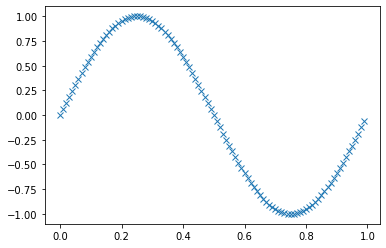

In [12]:
plt.plot(t.numpy(), waveform(t).detach().numpy(), 'x')

In [13]:
@torch.no_grad()
def perturb(model, noise):
    seed(0)
    for p in model.parameters():
        p += torch.normal(torch.zeros_like(p), noise)
    return model

In [14]:
@torch.no_grad()
def plot_model(model):
    y = model(t.unsqueeze(-1))
    plt.plot(t.numpy(), y.numpy())

In [15]:
def rel_mean_abs(x, tol=torch.tensor(1e-8)):
    xa = x.abs()
    xa_div = torch.fmax(xa.max(), tol)
    xa_mean = xa.mean()
    return xa_mean / xa_div

def mean_abs(x):
    return x.abs().mean()

In [16]:
def fit(model, optim_func, *, show_table, loss_fn=mse_loss, t=t, num_epochs=3, batch_size=None):
    model.train()
    # Expected param + labeled dataset.
    t = t.unsqueeze(-1)
    y = waveform(t)

    dataset = list(zip(t, y))
    if batch_size is None:
        # Go from SGD to simple GD.
        batch_size = len(dataset)
    loader = DataLoader(dataset, batch_size=batch_size)

    # Logging
    dfs = []

    activation_cls_set = (
        nn.ReLU,
        nn.Sigmoid,
    )
    
    with save_activations(model, activation_cls_set) as savers:
        
        def simple_log(epoch, batch_idx):
            if not show_table:
                return
            # Show err.
            activation_ratios = compute_activation_ratios(savers).numpy()
            activation_ratios_str = ", ".join([f"{x:.2f}" for x in activation_ratios])
            dp = p - p_prev
            dfs.append(pd.DataFrame(
                {
                    "epoch": epoch,
                    "batch_idx": batch_idx,
                    "mean|p|": mean_abs(p).detach().numpy(),
                    "mean|Δp|": mean_abs(dp).numpy(),
                    "loss": loss.detach().numpy(),
                    "activation_ratios": activation_ratios_str,
                },
                index=[len(dfs)],
            ))

        params = list(model.parameters())
        optim = optim_func(params)

        p = flat_cat_detached(params)
        print(f"Num param: {len(p)}")
        print(f"Num data: {len(y)}")
        p_prev = p.clone()
        with torch.no_grad():
            yh0 = model(t)
            loss = loss_fn(y, yh0)
        simple_log(epoch="pre-opt", batch_idx="n/a")

        for epoch in range(num_epochs):
            for batch_idx, (ti, yi) in enumerate(loader):
                optim.zero_grad()
                yhi = model(ti)
                loss = loss_fn(yi, yhi)
                loss.backward()
                optim.step()

#                 # SGD update, no momentum.
#                 with torch.no_grad():
#                     for param in params:
#                         v = param.grad  # velocity
#                         param -= lr * v  # step

                # Validation.
                # TODO(eric): Activation tracking across minibatches is weird.
                # For now, should be OK w/ batch_size=len(dataset).
                p = flat_cat_detached(params)
                simple_log(epoch, batch_idx)
                p_prev = p

    with torch.no_grad():
        yhf = model(t)
    plt.plot(t.numpy(), y.numpy(), linewidth=3, linestyle="--", color="g")
    plt.plot(t.numpy(), yhf.numpy(), color="k")
    plt.show()
    print(loss_fn)
    if show_table:
        display(pd.concat(dfs))

In [17]:
def make_model(num_hidden_units=3):
    seed(0)
    model = MLP(1, 1, num_hidden_units=num_hidden_units, num_layers=3, activation_cls=nn.ReLU)
    return model

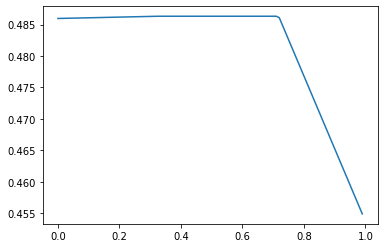

In [18]:
# Yup. It does a thing.
plot_model(make_model())

Num param: 66561
Num data: 100


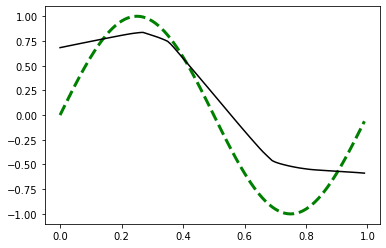

<function mse_loss at 0x7fa08b9c22f0>


In [19]:
# Yeah, I just dunno how to tune vanilla SGD for this.
fit(make_model(num_hidden_units=256), partial(SGD, lr=0.05), num_epochs=200, show_table=False)

Num param: 16897
Num data: 100


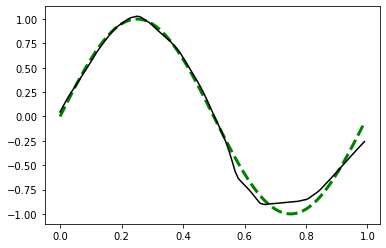

<function mse_loss at 0x7fa08b9c22f0>


In [20]:
# Noisy... merp. But slightly better.
fit(perturb(make_model(128), 0.5), partial(RMSprop, lr=0.005), show_table=False, num_epochs=500)

Num param: 10401
Num data: 100


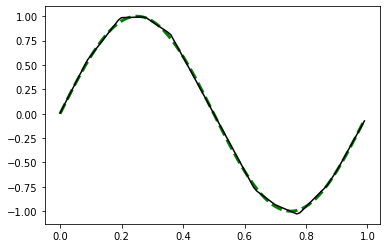

<function mse_loss at 0x7fa08b9c22f0>


In [21]:
# Decent-ish. A wee bit rough tho.
fit(make_model(num_hidden_units=100), partial(Adam, lr=0.1), num_epochs=300, show_table=False)

Num param: 40801
Num data: 100


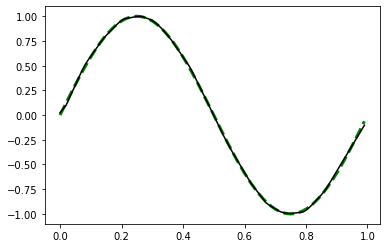

<function mse_loss at 0x7fa08b9c22f0>


In [22]:
fit(make_model(num_hidden_units=200), partial(Adam, lr=0.1), num_epochs=300, show_table=False)

Num param: 40801
Num data: 100


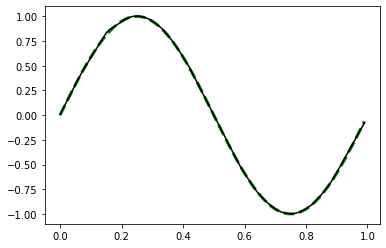

<function smooth_l1_loss at 0x7fa08be17950>


In [23]:
fit(make_model(num_hidden_units=200), partial(Adam, lr=0.01), loss_fn=F.smooth_l1_loss, num_epochs=150, show_table=False)